In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


Import libraries.

In [6]:
#GPU Compatible Imports
import tensorflow as tf
import lyricsgenius
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.layers import LSTM, Dropout, Dense, Bidirectional
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import to_categorical


Search top 10 most popular songs by artist.

In [7]:
#Using lyricsgenius package to load in artist and number of songs
artist = "Bob Dylan"
max_songs = 40
genius = lyricsgenius.Genius("aQ7lefZGur5adkObCa4UZE9olb-x-xxXeyxHPyyL8k0r6jejtCZsAytNZ4ww67Od") #Generic Genius account ID
artist = genius.search_artist(artist, max_songs=max_songs, sort="popularity")
songs=artist.songs

Searching for songs by Bob Dylan...

Song 1: "Blowin' in the Wind"
Song 2: "Make You Feel My Love"
Song 3: "All Along the Watchtower"
Song 4: "The Times They Are A-Changin'"
Song 5: "Like a Rolling Stone"
Song 6: "Hurricane"
Song 7: "Don't Think Twice, It's All Right"
Song 8: "Mr. Tambourine Man"
Song 9: "Tempest"
Song 10: "Subterranean Homesick Blues"
Song 11: "Masters of War"
Song 12: "To Fall In Love With You"
Song 13: "Desolation Row"
Song 14: "Tangled Up in Blue"
Song 15: "A Hard Rain's a-Gonna Fall"
Song 16: "Knockin' On Heaven's Door"
Song 17: "It's Alright, Ma (I'm Only Bleeding)"
Song 18: "It's All Over Now, Baby Blue"
Song 19: "Girl from the North Country"
Song 20: "Visions Of Johanna"
Song 21: "Duquesne Whistle"
Song 22: "Lay Lady Lay"
Song 23: "Ballad of a Thin Man"
Song 24: "Shelter From The Storm"
Song 25: "Idiot Wind"
Song 26: "My Back Pages"
Song 27: "Boots of Spanish Leather"
Song 28: "Forever Young (Slow Version)"
Song 29: "It Ain't Me, Babe"
Song 30: "Roll On John"
S

Compile list of lines from each type of song section.

In [8]:
#Separation of songs into sections for future adaptation of lyric generation
section_types={}
section_types[0]='All'
section_types[1]='Chorus'
section_types[2]='Verse'
section_types[3]='Pre-Chorus'
section_types[4]='Bridge'
section_types[5]='Break'
word=[]
bigolelist=[[] for z in range(0,len(section_types))]

In [9]:
#Append all lyrics from all loaded songs
for x in range(0,max_songs): #CHANGE RANGE FOR DIFFERENT # OF SONGS
    song=songs[x]
    lines=song.lyrics.split('\n')
    sections=song.lyrics.split('\n\n')
    for i in range(0,len(sections)):
        for j in range(0,len(lines)):
            for k in range(1,len(section_types)):
                if '['+section_types[k] in lines[j]:
                    bigolelist[k].append(lines[(j+1):])
                    bigolelist[0].append(' '.join(lines[(j+1):]))
                        

Create dictionary of words and characters.

In [10]:
allwords=' '.join(bigolelist[0])

In [11]:
#Filter out unnecessary punctuation and section titles from lyrics
allwords = allwords.replace("\\\'","")
allwords = allwords.replace('[','')
allwords = allwords.replace(']','')
allwords = allwords.replace(':','') #E.G. 'VERSE 2:'
allwords = allwords.replace('Intro','')
allwords = allwords.replace('Verse','')
allwords = allwords.replace('Pre-Chorus','')
allwords = allwords.replace('Chorus','')
allwords = allwords.replace('Bridge','')
allwords = allwords.replace('Outro','')
allwords = allwords.replace('”','')
allwords = allwords.replace('’','')
allwords = allwords.replace('\'','')
# allwords = allwords.replace(artist,'') #UNCOMMENT ELIMINTATES SELF NAME


# allwords  #UNCOMMENT PRINTS WHOLE TEXT

In [12]:
#Converts all text to 256 ASCII numeric representation
fullnum=[]
for c in range(0,len(allwords)):
    y=ord(allwords[c])
    if y<256:
        fullnum.append(y)
txtlength=len(fullnum)

#fullnum #UNCOMMENT PRINTS WHOLE TEXT IN ASCII NUMBER FORMAT

In [13]:
import nltk
# nltk.download() #Uncomment to download 'punkt' extension if prompted
sents=sent_tokenize(allwords) #SWAPPED FROM SENTENCES TO WORDS
sents=sent_tokenize(allwords)

In [14]:
#Appends ASCII characters to sequence inputs and outputs as training data
sequence_length=20
dataX=[]
dataY=[]
for i in range(0,txtlength-sequence_length):
    seq_in=allwords[i:i+sequence_length]
    seq_out=allwords[i+sequence_length]
    dataX.append(seq_in)
    dataY.append(seq_out)

In [15]:
#Filters out empty/ null/ NaN sequences
Y =  []
keep = []
data_X=np.asarray(dataX)
data_Y=np.asarray(dataY)
for i in range(0, len(data_X)):
    if int(ord(dataY[i]))<256:
        Y.append(int(ord(dataY[i])))
        keep.append(i)
        
        
        
x = np.zeros((len(Y),sequence_length))
for i in range(0,len(Y)):
    k=keep[i]
    for j in range(0, sequence_length):
       
        x[i, j] = ord(list(dataX[k])[j])
    
            
            


In [16]:
X = x/256
X=np.reshape(X,(np.shape(X)[0],sequence_length,1))

In [14]:
#Defines LSTM based model
model=Sequential()
model.add(LSTM(256,input_shape=(X.shape[1],X.shape[2]), return_sequences=True))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.25))
model.add(Dense(256,activation='softmax'))
opt = optimizers.Adam(lr=0.001, clipvalue=.5)
model.compile(loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'],optimizer=opt)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [15]:
#Fits and runs model for training
filepath='princeLR001clip5TWO.{epoch:02d}-{loss:.2f}.hdf5' #GENERIC FILENAME SAVE PATH USED FOR GENERATION MODEL LATER
checkpoint=ModelCheckpoint(filepath,verbose=1,save_best_only=False,period = 1)
callbacks_list=[checkpoint]
model.fit(X,Y,epochs=20,batch_size=512,callbacks=callbacks_list)

Epoch 1/20
8376631/8376631 [==============================]8376631/8376631 [==============================] - 1530s 183us/step - loss: 0.9294 - sparse_categorical_accuracy: 0.7545

Epoch 2/20
8376631/8376631 [==============================]8376631/8376631 [==============================] - 1531s 183us/step - loss: 0.2106 - sparse_categorical_accuracy: 0.9433

Epoch 3/20
8376631/8376631 [==============================]8376631/8376631 [==============================] - 1545s 184us/step - loss: 0.1480 - sparse_categorical_accuracy: 0.9587

Epoch 4/20
8376631/8376631 [==============================]8376631/8376631 [==============================] - 1561s 186us/step - loss: 0.1214 - sparse_categorical_accuracy: 0.9655

Epoch 5/20
8376631/8376631 [==============================]8376631/8376631 [==============================] - 1578s 188us/step - loss: 0.1065 - sparse_categorical_accuracy: 0.9692

Epoch 6/20
8376631/8376631 [==============================]8376631/8376631 [===================

In [32]:
import sys
#define LSTM model for lyric generation
model=Sequential()
model.add(LSTM(256,input_shape=(X.shape[1],X.shape[2]), return_sequences=True))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.25))
model.add(Dense(256,activation='softmax'))

filename = 'princeLR001clip5.10-0.07.hdf5' #CHANGE THIS TO MATCH A SAVED MODEL FROM ABOVE
model.load_weights(filename)

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam')

#define seed
#start = np.random.randint(0,len(dataX)-1) #UNCOMMENT THIS AND BELOW LINE FOR RANDOM PATTERN GENERATION
#our_seed= dataX[start] 

# our_seed = 'when i go and cry like a bab' #UNCOMMENT THIS OR BELOW LINE FOR PREDETERMINED SEEDS
# our_seed = 'when i look up i see a shining'
our_seed = 'hey yeah this is a song' #EDITABLE SEED, MUST BE OVER 20 CHARACTERS
pattern=[]
for c in range(sequence_length):
    num=ord(our_seed[c])
    pattern.append(num/256)

print('Seed: ')
print("\"",''.join([chr(int(value*256)) for value in pattern]), "\"")

Seed: 
" hey yeah this is a s "


In [33]:
len(pattern)
fullpattern=[]
fullpattern = pattern

In [34]:
#Generates text based on loaded model


for i in range(150):

    x = np.reshape(pattern,(1,sequence_length,1))

    prediction = model.predict(x,verbose = 0)

    index = np.argmax(prediction)
    print(index)
    result = chr(int(index))

    seq_in = [chr(int(value*256)) for value in pattern]

    #sys.stdout.write(result)

    pattern.append(index/256)
    pattern = pattern[1:len(pattern)]
    fullpattern.append(index/256)

#     if i%4==0:
#         print("\n")
print("\"",''.join([chr(int(value*256)) for value in fullpattern]), "\"")
print("\nDone!")

104
108
104
111
32
100
117
115
116
32
102
101
117
32
116
97
32
116
104
101
108
111
32
119
97
109
116
32
116
111
117
99
32
97
105
111
32
32
98
110
111
116
105
44
115
111
117
32
119
111
117
108
117
32
105
97
116
114
105
101
103
32
121
101
114
115
32
116
111
105
107
32
104
110
32
111
111
117
101
97
97
116
32
107
105
115
104
117
32
84
111
112
32
97
114
101
32
111
101
32
109
104
101
109
32
115
105
32
116
110
101
110
32
76
116
111
32
117
110
101
32
110
101
101
101
32
104
101
32
116
111
122
32
117
110
101
107
121
32
109
111
109
108
104
104
32
109
111
116
32
" hey yeah this is a shhlho dust feu ta thelo wamt touc aio  bnoti,sou woulu iatrieg yers toik hn ooueaat kishu Top are oe mhem si tnen Lto une neee he toz uneky momlhh mot  "

Done!


(0, 1)

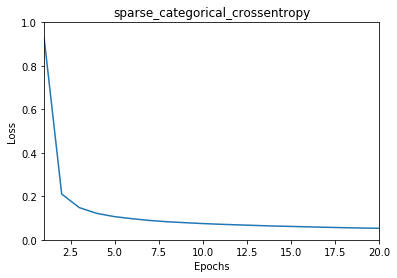

In [64]:
#Loss Plot
import matplotlib.pyplot as plt
the_loss = [0, .9294, .2106, .1480, .1214, .1065, .0970, .0889, .0830, .0787, .0747, .0714, .0686, .0660, .0633 ,.0616, .0594, .0575, .0558, .0542, .0530,]
the_acc = [0, .7545, .9433, .9587, .9655, .9692, .9718, .9740, .9756, .9767, .9777 ,.9787, .9794 ,.9802 ,.9809 ,.9814, .9820, .9825, .9830, .9835, .9838]
plt.plot(the_loss)
plt.title('sparse_categorical_crossentropy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim((1,20))
plt.ylim((0,1))

(0, 1)

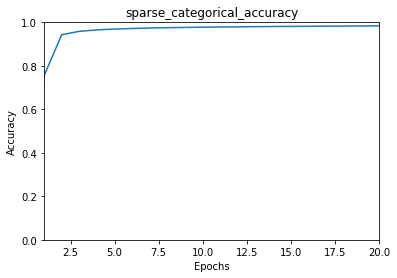

In [62]:
#Accuracy Plot
plt.plot(the_acc)
plt.title('sparse_categorical_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim((1,20))
plt.ylim((0,1))

(0.7, 1)

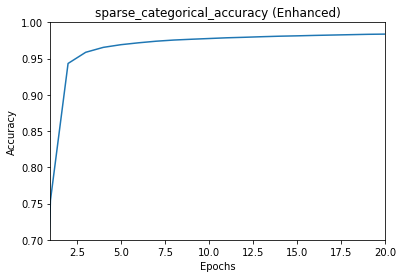

In [63]:
#Zoomed Accuracy Plot
plt.plot(the_acc)
plt.title('sparse_categorical_accuracy (Enhanced)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim((1,20))
plt.ylim((.7,1))